In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from load_dataset_AlexNet import load_dataset
import selectivesearch

In [365]:
def non_max_suppression_slow(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # initialize the list of picked indexes
    # 抑制されたboundingboxを格納する
    pick = []
 
    # grab the coordinates of the bounding boxes
    # 引数の boundingboxes から startX,startY,endX,endY をスライシングして取得
    x1 = boxes[:,1]
    y1 = boxes[:,2]
    x2 = boxes[:,3]
    y2 = boxes[:,4]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    # 各boundingboxの面積を計算する
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    # endYを昇順でソートし、ソート時のインデックスを取得する
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    # インデックスリストが空になるまでループする
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        # 現在のインデックスの長さを取得
        last = len(idxs) - 1
        # 現在のインデックスリストからの後ろ(bboxの右下座標が最も大きいもの)のインデックスを取得する
        i = idxs[last]
        # pickリストにインデックスを追加
        pick.append(i)
        # 現在のインデックスの長さを格納
        suppress = [last]
        
        # インデックスの中身を全て見る、overlapの値を計算する
        for pos in range(0,last):
            # ループ時のインデックスを取得
            j = idxs[pos]
            
            # 重複した部分の startX, startY, endX, endY を取得する
            xx1 = max(x1[i],x1[j])
            yy1 = max(y1[i],y1[j])
            xx2 = min(x2[i],x2[j])
            yy2 = min(y2[i],y2[j])    
            
            # 重複部分の幅と高さを計算
            w = max(0,xx2 - xx1 +1)
            h = max(0, yy2 - yy2 + 1)
            
            # overlap値を求めるため、重複部分の面積をとループ時のbounding box の面積で割る
            overlap = 100*float(w * h) / area[j]
            # もし求めたoverlap値が引数のしきい値より大きい = 重複していれば抑制、削除するためのリストに追加する
            if(overlap > overlapThresh and overlap < 1):
                suppress.append(pos)
        
        # 抑制するboundingboxのインデックスを削除する
        idxs = np.delete(idxs,suppress)
    # 残ったbounding boxの座標リストを返す
    return boxes[pick]

In [4]:
X = tf.placeholder(tf.float32, shape=[None, 224*224*3],name="input")
t = tf.placeholder(tf.float32, shape=[None, 4])
keep_prob = tf.placeholder(tf.float32,name="keep_prob")
### 入力層
input_layer = tf.reshape(X, [-1,224,224,3])

### 畳込み層、プーリング層1
h_conv1 = tf.layers.conv2d(inputs=input_layer,filters=96,kernel_size=[11, 11],strides=(4,4),padding='same',activation=tf.nn.relu)
h_norm1 = tf.nn.local_response_normalization(h_conv1,depth_radius=2,alpha=2e-5,beta=0.75)
h_pool1 = tf.layers.max_pooling2d(inputs=h_norm1,pool_size=(3,3),strides=(2,2),padding='same')

### 畳込み層、プーリング層2
h_conv2 = tf.layers.conv2d(inputs=h_pool1,filters=256,kernel_size=[5, 5],padding='same',activation=tf.nn.relu)
h_norm2 = tf.nn.local_response_normalization(h_conv2,depth_radius=2,alpha=2e-5,beta=0.75)
h_pool2 = tf.layers.max_pooling2d(inputs=h_norm2,pool_size=(3,3),strides=(2,2),padding='same')

### 畳込み層、プーリング層3
h_conv3_1 = tf.layers.conv2d(inputs=h_pool2,filters=384,kernel_size=[3, 3],padding='same',activation=tf.nn.relu)
h_conv3_2 = tf.layers.conv2d(inputs=h_conv3_1,filters=384,kernel_size=[3, 3],padding='same',activation=tf.nn.relu)
h_conv3_3 = tf.layers.conv2d(inputs=h_conv3_2,filters=256,kernel_size=[3, 3],padding='same',activation=tf.nn.relu)

h_pool3 = tf.layers.max_pooling2d(inputs=h_conv3_3,pool_size=(3,3),strides=(2,2),padding='same')

### 全結合層1

stddev = np.sqrt(1.0 / 7*7*256)
h_W_fc1 = tf.Variable(tf.truncated_normal([7*7*256,4096], stddev=stddev)) 
h_b_fc1 = tf.Variable(tf.constant(0.1, shape=[4096]))
h_pool3_flat = tf.reshape(h_pool3, [-1, 7*7*256])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, h_W_fc1) + h_b_fc1)

h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### 全結合層2

stddev = np.sqrt(1.0 / 4096)
h_W_fc2 = tf.Variable(tf.truncated_normal([4096,4096], stddev=stddev)) 
h_b_fc2 = tf.Variable(tf.constant(0.1, shape=[4096]))
h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, h_W_fc2) + h_b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

### 出力層
stddev = np.sqrt(2.0 / 4096)
W_fc3 = tf.Variable(tf.truncated_normal([4096,4], stddev=stddev))
b_fc3 = tf.Variable(tf.constant(0.1, shape=[4]))
fc = tf.nn.xw_plus_b(h_fc2_drop,W_fc3,b_fc3,name="output")
y_conv = tf.nn.softmax(fc,name="output2")
### 損失
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=y_conv))

### 学習op
optimizer = tf.train.AdamOptimizer(1e-6)
train_step = optimizer.minimize(loss)

### モデルの評価
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(t,1))
# 精度
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [253]:
def get_RegionProposal(img_path):
  # 300x300 のサイズでSelectiveSearchにかける
  im = Image.open(img_path, "r")
  im = im.resize((300,300))
  # SelectiveSearchで候補領域を得る
  img_lbl, regions = selectivesearch.selective_search(np.array(im), scale=300, sigma=0.7, min_size=10)
  candidates = set()
  for r in regions:
      # excluding same rectangle (with different segments)
      if r['rect'] in candidates:
          continue
      # excluding regions smaller than 2000 pixels
      if r['size'] < 2000:
          continue
      # distorted rects
      x, y, w, h = r['rect']
      if w / h > 1.2 or h / w > 1.2:
          continue
      candidates.add(r['rect'])
  bboxes = []
  region_images = []
  for x, y, w, h in candidates:
    # 候補領域を 224x224 のサイズで切り抜き
    tmp = im.crop((x,y,x+w,y+h))
    resize_img = tmp.resize((224,224))
    # 候補領域の(x,y)座標を格納
    bboxes.append(np.array([x,y,x+w,y+h]))
    region_images.append(resize_img)
  return region_images,bboxes

In [378]:
def predict_fromRegionProposal(orig_img,images,bboxes):
  # 候補領域から画像認識を行う
  tmp_bboxes = []
  ret_bboxes = []
  for i in range(0,len(bboxes)):
    startX,startY,endX,endY = bboxes[i]
    img = np.frombuffer(np.array(images[i]),dtype=np.uint8)
    img = img.astype(np.float32)
    img /= 255.0
    ans = sess.run(y_conv,feed_dict={X:np.array(img).reshape(-1,224*224*3),keep_prob:1.0})
    p = np.argmax(ans,axis=1)
    # 確率が0.6以上の候補領域を採用する
    if(ans[:,p] > 0.6):
      tmp_bboxes.append(np.array([p,startX,startY,endX,endY]))
      if(p == 0):
        cv2.rectangle(orig_img,(startX,startY),(endX,endY),(255,0,0),2)
      elif(p == 1):
        cv2.rectangle(orig_img,(startX,startY),(endX,endY),(0,255,0),2)
      elif(p == 2):
        cv2.rectangle(orig_img,(startX,startY),(endX,endY),(0,0,255),2)
      elif(p == 3):
        cv2.rectangle(orig_img,(startX,startY),(endX,endY),(30,10,30),2)
      
  if(len(tmp_bboxes) > 1):
    # 採用した候補領域の重複を削除する
    ret_bboxes = non_max_suppression_slow(np.array(tmp_bboxes),0.3)

  return ret_bboxes

In [ ]:
saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('./RoadSign-Alexnet-ckpt')
if ckpt:
  # checkpointファイルから最後に保存したモデルへのパスを取得する
  last_model = ckpt.model_checkpoint_path
  print("load {0}".format(last_model))
  # 学習済みモデルを読み込む
  saver.restore(sess, last_model)

In [424]:
img_path = "./R-CNN_images/testimage.jpg"
orig_img = cv2.imread(img_path)
orig_img = cv2.resize(orig_img,(300,300))
out_img = orig_img.copy()
# 候補領域を取得する
get_region_image,get_bboxes = get_RegionProposal(img_path)

In [425]:
get_bboxes

[array([ 77,   0, 225, 174]),
 array([ 77,  35, 224, 174]),
 array([  0,  27,  95, 125]),
 array([149,  73, 299, 299]),
 array([ 78,  35, 220, 168]),
 array([ 92,  69, 211, 199]),
 array([ 92,  69, 211, 153]),
 array([156,   0, 209,  85]),
 array([161,  73, 299, 299]),
 array([  0, 241, 100, 299]),
 array([ 77,  35, 220, 169]),
 array([  0, 131, 105, 298]),
 array([113,   0, 155,  70]),
 array([ 92,  69, 211, 249]),
 array([ 77,  35, 225, 174]),
 array([  0,   0, 236, 299]),
 array([155,   0, 227, 128]),
 array([  0, 101, 105, 298]),
 array([158,   0, 209,  85]),
 array([109,  80, 193, 141]),
 array([ 92,  69, 211, 299]),
 array([ 74,   0, 236, 174]),
 array([ 78,  35, 220, 165]),
 array([156,   0, 227, 128]),
 array([  0,   0, 236, 174]),
 array([ 74,   0, 225, 174]),
 array([  0, 131, 105, 257]),
 array([  0,   0, 299, 299])]

In [426]:
bboxes = predict_fromRegionProposal(orig_img,get_region_image,get_bboxes)

In [427]:
bboxes

array([[array([1]), 0, 0, 299, 299],
       [array([1]), 92, 69, 211, 153],
       [array([1]), 109, 80, 193, 141],
       [array([1]), 0, 27, 95, 125],
       [array([2]), 113, 0, 155, 70]], dtype=object)

In [428]:
# 候補領域を四角で囲む
for(idx,startX,startY,endX,endY) in bboxes:
  if(idx == 0):
    cv2.rectangle(out_img,(startX,startY),(endX,endY),(255,0,0),2)
  elif(idx == 1):
    cv2.rectangle(out_img,(startX,startY),(endX,endY),(0,255,0),2)
  elif(idx == 2):
    cv2.rectangle(out_img,(startX,startY),(endX,endY),(0,0,255),2)
  elif(idx == 3):
    cv2.rectangle(out_img,(startX,startY),(endX,endY),(30,10,30),2)

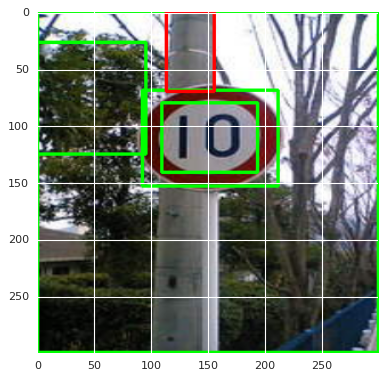

In [429]:
# 止まれなら青
# 制限速度10なら緑
# 制限速度20なら赤
# 制限速度30なら黒
plt.imshow(cv2.cvtColor(out_img,cv2.COLOR_BGR2RGB))